In [1]:
import numpy as np
import anndata as ad
import pandas as pd
from pyprojroot.here import here
import os
import re
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
CELL_TYPES=["Mono", "T_CD4_Naive", "T_CD4_NonNaive", "T_CD8_Naive", "T_CD8_NonNaive", "B", "Plasma", "UTC", "ILC", "pDC", "DC"]

In [3]:
def load_sorted_shap_values_fnames(
    cell_type: str = '',
    run_name: str = 'run1'):

    dirpath = here(f"inflammabucket_bkp/03_downstream_analysis/05_SHAP/results/04_shap/shap_vals")
    fname_regex = f'^{run_name}_{cell_type}_shap_values_' + r'(\d+)'
    results_batches = [
        (fname, int(re.search(fname_regex, fname).group(1)))
        for fname in os.listdir(dirpath)
        if re.search(fname_regex, fname)]

    sorted_files = sorted(results_batches, key=lambda x: x[1])

    sorted_filenames = [os.path.join(dirpath, filename) for filename, _ in sorted_files]

    return sorted_filenames

In [4]:
DISEASES = ['BRCA', 'CD', 'COPD', 'COVID', 'CRC', 'HBV', 'HIV', 'HNSCC', 'MS', 'NPC', 'PS', 'PSA', 'RA', 'SLE', 'UC', 'asthma', 'cirrhosis', 'flu', 'healthy', 'sepsis']
def extract_data_sample_wise_shap(cell_type, selected_gene_symbol='CYBA'):
    adata = ad.read_h5ad(here(f'inflammabucket_bkp/03_downstream_analysis/05_SHAP/data/{cell_type}_adataMerged_SPECTRAgenes.log1p.h5ad'), backed='r')
    symbols_df = pd.read_pickle(here('inflammabucket_bkp/03_downstream_analysis/04_selected_gene_list.pkl'))
    symbols_sorted = symbols_df.loc[adata.var_names].symbol.values
    gene_idx = np.nonzero(symbols_sorted == selected_gene_symbol)[0][0]
    
    output_shap = []
    for fname in tqdm(load_sorted_shap_values_fnames(cell_type), leave=False):
        batch_of_shap = np.load(fname)['shap_values']
        output_shap.append(batch_of_shap[:,gene_idx,:])
    output_shap = np.concatenate(output_shap)
    
    data = (pd.DataFrame(np.c_[output_shap, adata.obs.sampleID.values], columns=DISEASES+['sampleID'])
     .groupby('sampleID')
     .mean()
     .merge(adata.obs[['disease', 'sampleID']].groupby('sampleID',observed=True).first(), right_index=True, left_index=True)
     .melt(id_vars='disease', var_name="SHAP disease", value_name="SHAP value")
    )
    data['sample with disease'] = data.disease==data['SHAP disease']

    return data

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

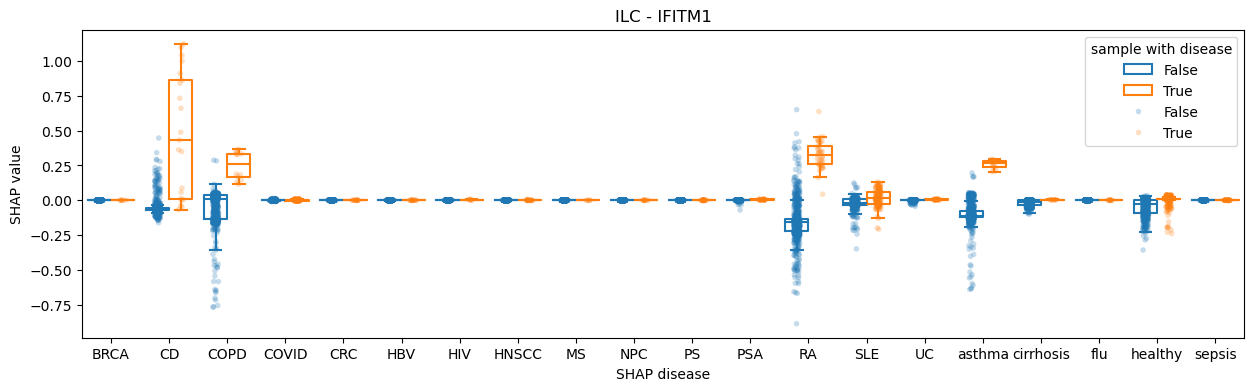

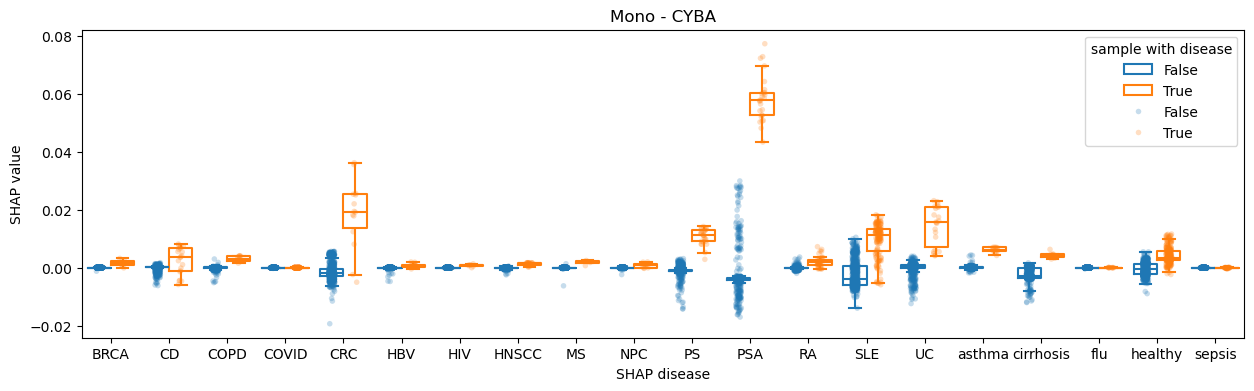

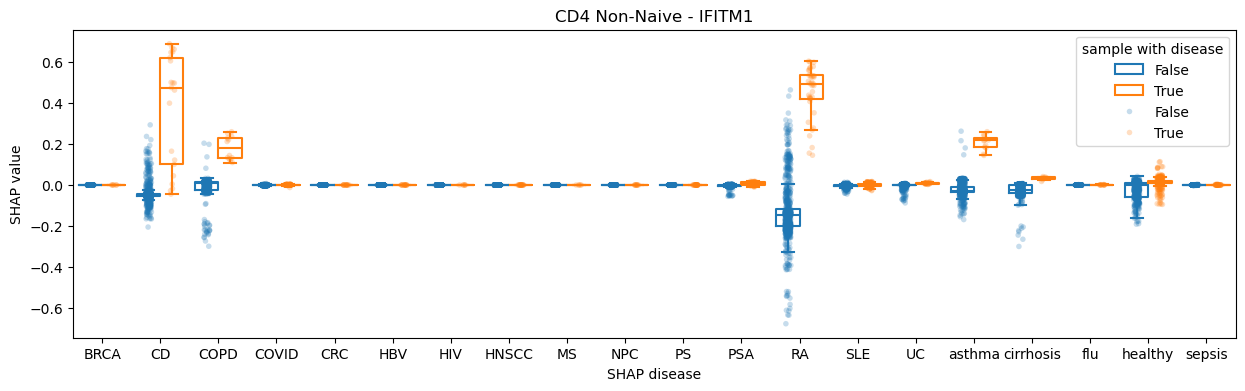

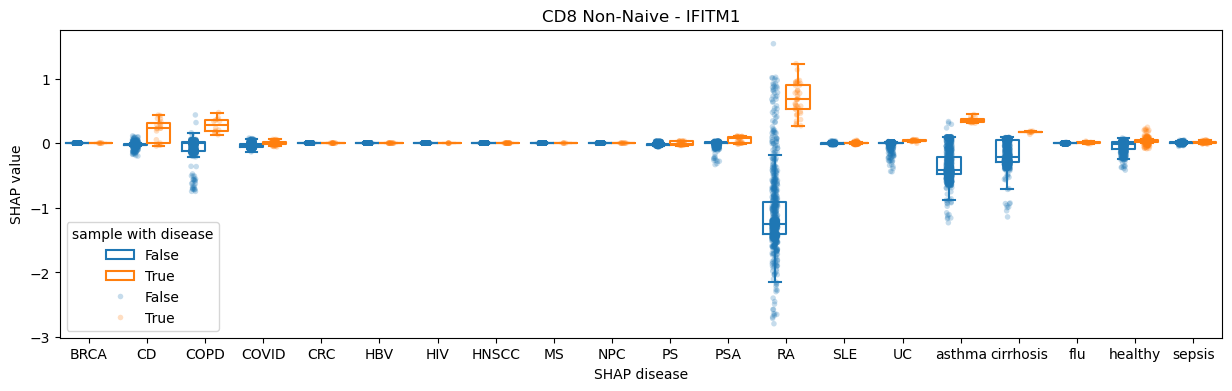

In [5]:
cell_type_map=dict(
    Mono='Mono',
    ILC='ILC',
    T_CD4_NonNaive='CD4 Non-Naive',
    T_CD8_NonNaive='CD8 Non-Naive'
)
for cell_type, gene in [('ILC', 'IFITM1'), ('Mono', 'CYBA'), ('T_CD4_NonNaive', 'IFITM1'), ('T_CD8_NonNaive', 'IFITM1')]:
    data = extract_data_sample_wise_shap(cell_type, gene)
    
    cell_type_name = cell_type_map[cell_type]
    
    plt.figure(figsize=(15,4))
    sns.boxplot(x="SHAP disease", y="SHAP value", hue="sample with disease", data=data, showfliers=False, fill=False)
    sns.stripplot(x="SHAP disease", y="SHAP value", hue="sample with disease", dodge=True, alpha = 0.25, size=4, data=data, **{'rasterized':True})
    
    
    plt.title(f'{cell_type_name} - {gene}')
    plt.savefig(f'results/samplewise_shap_{cell_type}_{gene}.pdf', dpi=1200, bbox_inches='tight')